# Setup

 Import standard modules

In [370]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
os.chdir('/home/chris/projects/tidal_flat_0d')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src import features, models
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [3]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)
# tides = tides.iloc[:int(len(tides) * 0.35)]

In [750]:
from src import models2
tf = models2.TidalFlat(
    tide_ts=tides,
    land_elev_init=1.15,
    conc_bound=0.9,
    grain_diam=3.5e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate_yr=2e-4,
    comp_rate_yr=-4e-3,
    sub_rate_yr=-3e-3,
    slr_yr=0.005,
)
tf.run()

Progress:   3%|▎         | 5/194.0 [00:03<01:52,  1.68inundation/s]

KeyboardInterrupt: 

In [740]:
tf.inundations[0]

Inundation @22f130 
tide_ts=1817130    1.149629
1817131    1.149664
1817132    1.149699
1817133    1.149734
1817134    1.149769
             ...   
1821454    1.149790
1821455    1.149755
1821456    1.149720
1821457    1.149685
1821458    1.149650
Length: 4329, dtype: float64
land_elev_init=1.1496081784627092
pos_start=1817130
pos_end=1821458
pos_slack=1819295
tide_elev_slack=1.1859252183651332
period=4328
params=params(tide_elev_func=<scipy.interpolate.fitpack2.InterpolatedUnivariateSpline object at 0x7f466d22f430>, conc_bound=0.9, settle_rate=0.001100458333333333, bulk_dens=900, linear_rate_sec=-2.156265854895992e-10)
flood=  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 791
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f469972b160>
   status: 0
  success: True
        t: array([1817130.        , 1817130.00092447, 1817130.01016913,
       1817130.05050471, 1817130.09598784, 1817130.15966008,
   

<AxesSubplot:>

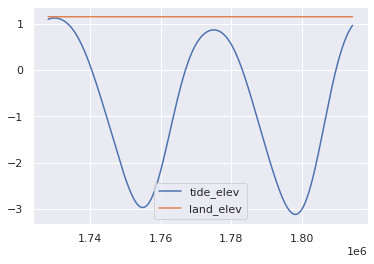

In [724]:
start = 60*60*24*20
day = 60 * 60 * 24
tf.results.loc[start:start + 1 * day].plot()

<AxesSubplot:>

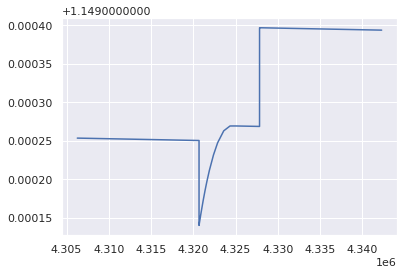

In [789]:
I = tf.inundations[3]
i = I.pos_start
tf.results.land_elev[i-day/6:i+day/4].plot()

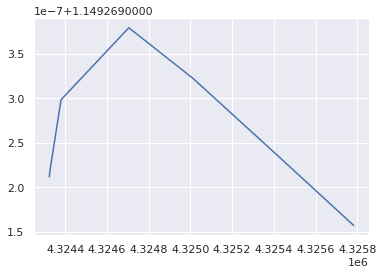

In [793]:
plt.plot(I.ebb.t, I.ebb.y[2])

In [797]:
I.period * I.params.linear_rate_sec * 1000

-0.001543023845763572